# **Tracking single-cell segmentations over the course of time**

This notebook uses Trackpy to track the trajectory of cells over a course of a tiff stack. It uses Cellpose for the segmentation. It is recommended you have a GPU and use Google Colab.

Trackpy strongly recommends using Conda and not pip. Therefore, we need to set up conda environment for our colab notebook.
Trackpy install: http://soft-matter.github.io/trackpy/dev/installation.html

Let us start by understanding the current python version in our colab and installing the corresponding conda environment.

In [ ]:
#Path and version numbers for python
!which python
!python --version

/usr/local/bin/python
Python 3.7.13


This is python 3.7.13.
https://docs.conda.io/en/latest/miniconda.html#system-requirements
The documentation recommends miniconda 4.12.0 for python 3.7 Linux 64 bit

In [ ]:
%env PYTHONPATH=

env: PYTHONPATH=


In [ ]:
%%bash
MINICONDA_INSTALLER_SCRIPT=Miniconda3-py37_4.12.0-Linux-x86_64.sh
MINICONDA_PREFIX=/usr/local
wget https://repo.continuum.io/miniconda/$MINICONDA_INSTALLER_SCRIPT
chmod +x $MINICONDA_INSTALLER_SCRIPT
./$MINICONDA_INSTALLER_SCRIPT -b -f -p $MINICONDA_PREFIX

Verify to see if the conda executable is available

In [ ]:
!which conda # should return /usr/local/bin/conda

/usr/local/bin/conda


Confirm the conda version

In [ ]:
!conda --version # should return 4.12.0
!python --version

conda 4.12.0


Update conda

In [ ]:
%%bash
conda install --channel defaults conda python=3.7 --yes
conda update --channel defaults --all --yes
!conda --version # updated version of conda
!python --version

Provide directory where site packages are installed within miniconda

First, check the current paths.

In [ ]:
import sys
sys.path

['',
 '/content',
 '/env/python',
 '/usr/lib/python37.zip',
 '/usr/lib/python3.7',
 '/usr/lib/python3.7/lib-dynload',
 '/usr/local/lib/python3.7/dist-packages',
 '/usr/lib/python3/dist-packages',
 '/usr/local/lib/python3.7/dist-packages/IPython/extensions',
 '/root/.ipython']

Now add the path for our site-packages

In [ ]:
import sys
_ = (sys.path
        .append("/usr/local/lib/python3.7/site-packages"))

Now, we are all set to install trackpy library using conda.

Please note that you will be prompted to answer Yes/No a couple of times.

In [ ]:
!conda install -c conda-forge trackpy
!conda install -c conda-forge pims

Solving environment: - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - done

## Package Plan ##

  environment location: /usr/local

  added / updated specs:
    - trackpy


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    bottleneck-1.3.5           |   py37h7deecbd_0         115 KB
    ca-certificates-2022.6.15  |       ha878542_0         149 KB  conda-forge
    certifi-2022.6.15          |   py37h89c1867_0         155 KB  conda-forge
    conda-4.13.0               |   py37h89c1867_1         989 KB  conda-forge
    cycler-0.11.0              |     pyhd8ed1ab_0          10 KB  conda-forge
    freetype-2.10.4            |       h0708190_1         890 KB  conda-forge
    icu-67.1                   |       he1b5a44_0        12.9 MB  conda-forge
    kiwisolver-1.4.

Import the required libraries

In [ ]:
# for interactive plotting
%matplotlib inline

import numpy as np
import pandas as pd

import pims
import trackpy as tp
import os

import matplotlib  as mpl
import matplotlib.pyplot as plt

# Optionally, tweak styles.
mpl.rc('figure',  figsize=(10, 6))
mpl.rc('image', cmap='gray')

Imageio: 'ffmpeg-linux64-v3.3.1' was not found on your computer; downloading it now.
Try 1. Download from https://github.com/imageio/imageio-binaries/raw/master/ffmpeg/ffmpeg-linux64-v3.3.1 (43.8 MB)
Downloading: 8192/45929032 bytes (0.0%)3522560/45929032 bytes (7.7%)7503872/45929032 bytes (16.3%)11059200/45929032 bytes (24.1%)15155200/45929032 bytes (33.0%)18923520/45929032 bytes (41.2%)22863872/45929032 bytes (49.8%)26468352/45929032 bytes (57.6%)30244864/45929032 bytes (65.9%)34070528/45929032 bytes (74.2%)38060032/45929032 bytes (82.9%)42213376/45929032 bytes (91.9%)45929032/45929032 bytes (100.0%)
  Done
File saved as /root

Trackpy offers various ways to segment your images (e.g., tp.locate for blob detection) but we will be using Stardist as it provides a robust deep learning based pre-trained models to segment fluorescence images. You can also train your own models. Please watch my tutorials on this topic.

In [ ]:
!pip install "opencv-python-headless<4.3"
!pip install cellpose

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 3.0 MB 6.9 MB/s 
     |████████████████████████████████| 69 kB 8.9 MB/s 
     |████████████████████████████████| 3.3 MB 56.0 MB/s 
     |████████████████████████████████| 13.5 MB 42.2 MB/s 
     |████████████████████████████████| 2.9 MB 46.4 MB/s 
     |████████████████████████████████| 40 kB 6.7 MB/s 
     |████████████████████████████████| 34.5 MB 1.2 MB/s 
     |████████████████████████████████| 6.4 MB 50.2 MB/s 
     |████████████████████████████████| 1.9 MB 44.3 MB/s 


In [ ]:
!nvcc --version
!nvidia-smi

import os, shutil, cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from cellpose import core, utils, io, models, metrics
import skimage.io
from skimage.measure import label, regionprops
from glob import glob

use_GPU = core.use_gpu()
yn = ['NO', 'YES']
print(f"Is the User's GPU activated? {yn[use_GPU]}")

In [ ]:
from stardist.data import test_image_nuclei_2d
from stardist.plot import render_label
from csbdeep.utils import normalize
import matplotlib.pyplot as plt

In [ ]:
#@markdown ###Custom model path (full path):

model_path = "/content/gdrive/MyDrive/colab_test/green_model_train/models/CP_tissuenet4" #@param {type:"string"}

#@markdown ###Path to output folder:

output_folder = "/content/gdrive/MyDrive/colab_test/Well_A3_Output" #@param {type:"string"}

#@markdown ###Channel Parameters:

Channel_to_use_for_segmentation = "Grayscale" #@param ["Grayscale", "Blue", "Green", "Red"]

# @markdown (Not Recommended)If you have a secondary channel that can be used, for instance nuclei, choose it here:

Second_segmentation_channel= "None" #@param ["None", "Blue", "Green", "Red"]


# Here we match the channel to number
if Channel_to_use_for_segmentation == "Grayscale":
  chan = 0
elif Channel_to_use_for_segmentation == "Blue":
  chan = 3
elif Channel_to_use_for_segmentation == "Green":
  chan = 2
elif Channel_to_use_for_segmentation == "Red":
  chan = 1


if Second_segmentation_channel == "Blue":
  chan2 = 3
elif Second_segmentation_channel == "Green":
  chan2 = 2
elif Second_segmentation_channel == "Red":
  chan2 = 1
elif Second_segmentation_channel == "None":
  chan2 = 0

#@markdown ### Segmentation parameters:

#@markdown diameter of cells (set to zero to use diameter from training set):
diameter =  0#@param {type:"number"}
#@markdown threshold on flow error to accept a mask (set higher to get more cells, e.g. in range from (0.1, 3.0), OR set to 0.0 to turn off so no cells discarded):
flow_threshold = 1 #@param {type:"slider", min:0.0, max:3.0, step:0.1}
#@markdown threshold on cellprob output to seed cell masks (set lower to include more pixels or higher to include fewer, e.g. in range from (-6, 6)):
cellprob_threshold=-1 #@param {type:"slider", min:-6, max:6, step:1}


In [ ]:
import pims

# Load TIFF stack
stack_img = pims.open(input_folder)

In [ ]:
stack_img

In [ ]:
# Initialize Cellpose model
model = models.Cellpose(gpu=True, pretrained_model = model_path)  # Or False if you don't have GPU

# Define a function for Cellpose segmentation
def cellpose_segmentation(frame):
    # Assuming `frame` is a single image frame
    # Perform Cellpose segmentation on the frame
    masks, flows, styles = model.eval(frame,
                                       channels=[chan, chan2],
                                       diameter=diameter,
                                       flow_threshold=flow_threshold,
                                       cellprob_threshold=cellprob_threshold)
    # Return the segmentation mask
    return masks

# Apply the function using @pims.pipeline
@pims.pipeline
def cellpose_segm(frames):
    # Apply Cellpose segmentation to each frame
    segmented_frames = [cellpose_segmentation(frame) for frame in frames]
    return segmented_frames

# Apply the segmentation pipeline to the TIFF stack
segmented_stack = cellpose_segm(stack_img)

# `segmented_stack` now contains the segmented masks for each frame in the TIFF stack
# You can further process or save these masks as needed


#Un-comment code if you want to save your segmented images (code used from cellpose function)
#io.save_masks(images,
              #masks,
              #flows,
              #files,
              #channels=[chan, chan2],
              #png=True, # save masks as PNGs and save example image
              #tif=True, # save masks as TIFFs
              #save_txt=True, # save txt outlines for ImageJ
              #save_flows=False, # save flows as TIFFs
              #save_outlines=False, # save outlines as TIFFs
              #)


(-0.5, 651.5, 475.5, -0.5)

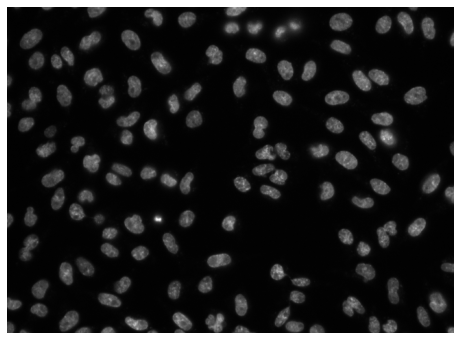

In [ ]:
plt.figure(figsize=(8,8))
plt.imshow(stack_img[0], cmap='gray') #change to see each frame
plt.axis("off")

Define a function for Stardist based segmentation and decorate it with pims.pipeline. This allows us to use the Stardist based segmentation for our timeseries.

Apply the segmentation function to out time series data set.

In [ ]:
segmented_stack

(TiffStack_tifffile,) processed through proc_func. Original repr:
    <Frames>
    Source: /content/drive/MyDrive/ColabNotebooks/data/tracking_data/Cell-counting-time-series.tif
    Length: 39 frames
    Frame Shape: (476, 652)
    Pixel Datatype: uint16

Plot a few images from our time series along with corresponding segmentation result.

In [ ]:
img_num = 5
plt.subplot(1,2,1)
plt.imshow(stack_img[img_num], cmap="gray")
plt.axis("off")
plt.title("input image")

plt.subplot(1,2,2)
plt.imshow(render_label(segmented_stack[img_num], img=stack_img[img_num]))
plt.axis("off")
plt.title("prediction + input overlay")

Let us use skimage.measure.regionprops to extract the centroid coordinates for all our objects.

In [ ]:
import skimage

In [ ]:
features = pd.DataFrame()
for num, img in enumerate(stack_img):
    for region in skimage.measure.regionprops(segmented_stack[num], intensity_image=img):
        # Store features
        features = features.append([{'y': region.centroid[0],
                                     'x': region.centroid[1],
                                     'frame': num,
                                     'area': region.area,
                                     },])

In [ ]:
features.head

<bound method NDFrame.head of              y           x  frame  area
0    21.354196  486.631579      0   703
0   163.477927  272.452975      0   521
0    17.804435  262.038306      0   496
0   222.848297  495.453560      0   646
0   466.007937  418.968254      0   378
..         ...         ...    ...   ...
0   472.888889  228.543210     38    81
0    45.207143  648.057143     38   140
0   433.381679    4.206107     38   131
0   472.071429  107.214286     38   168
0   473.809524  429.500000     38    42

[5166 rows x 4 columns]>

You can use tp.annotate to display the objects that we will be tracking.

In [ ]:
tp.annotate(features[features.frame==(0)], stack_img[0])

In [ ]:
#Plot object areas to investigate the distribution. You can further filter out objects based on size or intensity. Not required in our case.
fig, ax = plt.subplots()
ax.hist(features['area'], bins=20)

# Optionally, label the axes.
ax.set(xlabel='area', ylabel='count');

Every frame's particle locations are known to us. After that, we'll keep track of the particles frame by frame while assigning an identification number to each one.
Use trackpy.link_df to link a DataFrame of coordinates into trajectories.

In [ ]:
# The maximum displacement, or the distance an object can travel between frames, must be specified.
# We allow for the possibility that an object might be missed for a few frames and then seen again.
# Memory keeps track of disappeared objects and maintains their ID for up to some number of frames after their last appearance.
search_range = 11
t = tp.link_df(features, search_range, memory=5) #5 frames
t.head()

Frame 38: 134 trajectories present.


,y,x,frame,area,particle
0,21.354196,486.631579,0,703,0
0,412.282883,563.109910,0,555,1
0,115.829588,185.440075,0,534,2
0,432.588785,506.389408,0,321,3
0,464.395095,535.062670,0,367,4


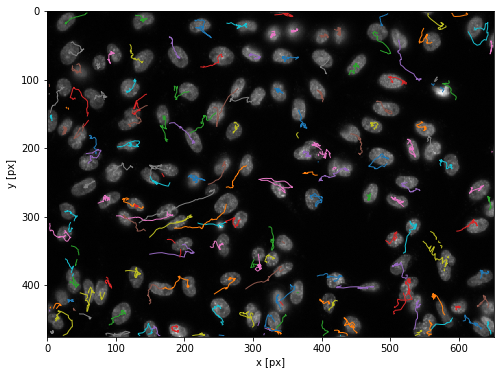

In [ ]:
#Plot trajectories
tp.plot_traj(t, superimpose=img) #Remove the superimpose part to just plot the trajectories.

Is there an overall drift? If so, we need to correct for it.

In [ ]:
drift = tp.compute_drift(t)

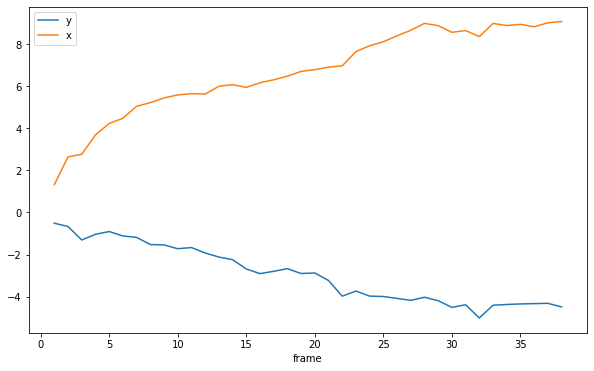

In [ ]:
drift.plot()
plt.show()

In [ ]:
t_corrected = tp.subtract_drift(t.copy(), drift)

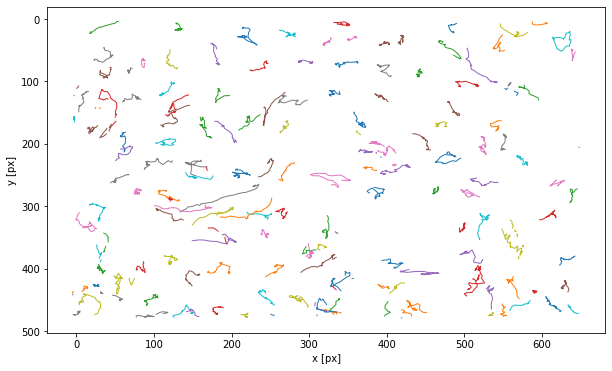

In [ ]:
ax = tp.plot_traj(t_corrected)
plt.show()

Compute the mean squared displacement (MSD) of each particle using the imsd function, and plot MSD vs. lag time.

In [ ]:
im = tp.imsd(t_corrected, 0.545, 0.0057)  # microns per pixel = 0.545, frames per second = .0057 (1 frame per about 3 mins)

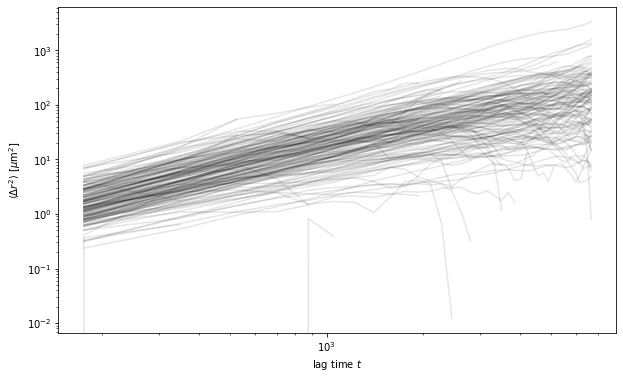

In [ ]:
fig, ax = plt.subplots()
ax.plot(im.index, im, 'k-', alpha=0.1)  # black lines, semitransparent
ax.set(ylabel=r'$\langle \Delta r^2 \rangle$ [$\mu$m$^2$]',
       xlabel='lag time $t$')
ax.set_xscale('log')
ax.set_yscale('log')

Ensemble Mean Squared Displacement



In [ ]:
em = tp.emsd(t_corrected, 0.545, 0.0057)  # microns per pixel = 0.545, frames per second = .0057 (1 frame per about 3 mins)

motion.py (235): Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.median(level=1) should use df.groupby(level=1).median().
motion.py (236): Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.median(level=1) should use df.groupby(level=1).median().


[Text(0, 0.5, '$\\langle \\Delta r^2 \\rangle$ [$\\mu$m$^2$]'),
 Text(0.5, 0, 'lag time $t$')]

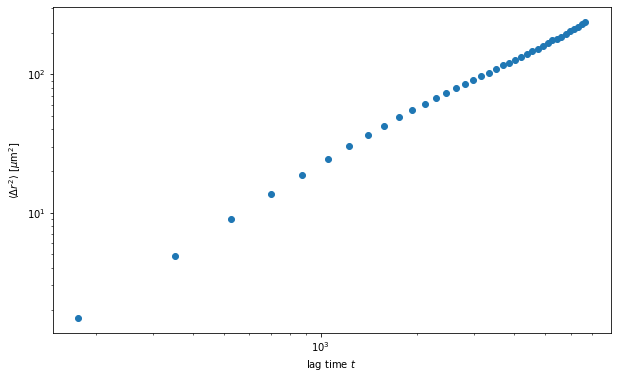

In [ ]:
fig, ax = plt.subplots()
ax.plot(em.index, em, 'o')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set(ylabel=r'$\langle \Delta r^2 \rangle$ [$\mu$m$^2$]',
       xlabel='lag time $t$')


Fit this ensemble mean-squared displacement to a power law.
Linear regression in log space.

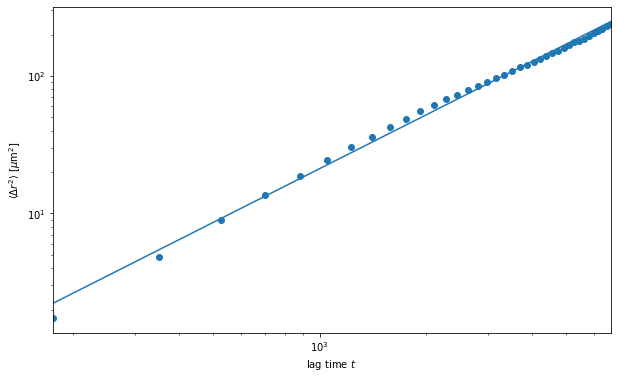

,n,A
msd,1.297218,0.002716


In [ ]:
plt.figure()
plt.ylabel(r'$\langle \Delta r^2 \rangle$ [$\mu$m$^2$]')
plt.xlabel('lag time $t$');
tp.utils.fit_powerlaw(em)  # performs linear best fit in log space, plots]

Plotting velocity fields

Pivot the dataframe (t) to get objects/particles in column for each row corresponding to a frame. This is to make it easy for us to perform velocity field calculations for each object.

In [ ]:
unstacked = t.set_index(['frame', 'particle']).unstack()

In [ ]:
unstacked

y                                                  \
particle        0           1           2           3           4     
frame                                                                 
0         21.354196  412.282883  115.829588  432.588785  464.395095   
1         19.303989  417.452424  114.940433  431.595568  461.851240   
2         21.308451  418.927126  112.241681  432.724832  456.378049   
3         20.547222  416.396296  109.575000  428.748466  451.021672   
4         19.737127  415.725146  110.651568  426.540470  448.401662   
5         18.230041  417.179191  110.783133  426.375281  443.643432   
6         16.150943  418.084906  111.673841  425.321199  439.523546   
7         14.554930  417.876155  113.763754  423.444668  437.803714   
8         12.221918  416.843100  113.427586  421.099502  435.757835   
9         10.605263  417.571150  113.836770  420.577348  433.920424   
10         8.885993  416.232422  111.676056  421.988208  432.195122   
11         8.320922  416.336634  111.750000  421.863850  430.714689   
12         7.624277  416.888235  110.435714  421.988713  431.893688   
13         7.426357  415.406427  109.896226  420.505344         NaN   
14         7.028689  416.732955  111.312160  412.807870  428.414330   
15         6.762527  416.370370  112.634508  409.090909  427.766447   
16         5.861183  417.433645  115.144144  407.611494  427.929530   
17         5.300300  420.579268  118.514286  404.778049  429.257525   
18         4.887097  418.864224  120.194545  404.055825  429.095082   
19         4.149020  415.562914  123.311808  402.777293  428.493750   
20              NaN  414.524229  125.157303  400.342529  431.802857   
21              NaN  414.211297  125.920518  398.409836  431.652406   
22              NaN  414.789474  125.179439  396.823799  431.881266   
23              NaN  412.886022  127.485660  396.118681  433.522427   
24              NaN  415.838074  128.011299  395.295455  431.153465   
25              NaN  416.757937  129.400000  395.703704  431.398417   
26              NaN  416.666667  128.783582  395.964371  428.500000   
27              NaN  415.766260  128.910816  396.874477  427.180593   
28              NaN  413.834971  129.107287  398.734694  426.325069   
29              NaN  416.382479  127.612121  390.439815  425.094086   
30              NaN  418.863341  126.283433  395.901288  424.793566   
31              NaN  424.848049  124.743243  396.585781  423.369272   
32              NaN  426.685009  123.108257  390.828042  421.903581   
33              NaN  431.269871  122.867890  394.646753  422.928571   
34              NaN  430.714286  121.578014         NaN  424.287749   
35              NaN  432.397338  118.810376  396.487342  424.400576   
36              NaN  437.188406  118.429319  396.026627  426.784416   
37              NaN  440.196296  118.457243  395.782123  426.835580   
38              NaN  443.319569  117.701695  396.986034  427.657754   

                                                                      ...  \
particle         5           6           7           8           9    ...   
frame                                                                 ...   
0         427.418386  285.018779  251.185185  379.328872  198.425474  ...   
1         426.219424  282.220930  247.642586  379.212844  197.953297  ...   
2         424.771639  278.514673  237.382979  378.971963  198.195312  ...   
3         422.930909  275.328194  233.419453  378.808880  197.708791  ...   
4         422.685152  272.703549  230.843666  379.161850  198.398990  ...   
5         422.019400  272.860125  228.629353  379.445087  197.915567  ...   
6         421.830479  272.639511  226.433962  379.896750  196.551913  ...   
7         420.948097  272.885010  226.128329  381.456140  196.154696  ...   
8         419.824138  272.957895  226.540046  382.141509  194.661654  ...   
9         418.782161  274.806378  226.551570  383.665370  192.660333  ...   
10        417.214286  274.712589  

In [ ]:
#Velocity field calculation
data = pd.DataFrame()
for item in set(t.particle):
    sub = t[t.particle==item]
    dvx = np.diff(sub.x)
    dvy = np.diff(sub.y)
    for x, y, dx, dy, frame in zip(sub.x[:-1], sub.y[:-1], dvx, dvy, sub.frame[:-1],):
        data = data.append([{'dx': dx,
                             'dy': dy,
                             'x': x,
                             'y': y,
                             'frame': frame,
                             'particle': item,
                            }])

###Plotting the velocity fields

(-0.5, 651.5, 475.5, -0.5)

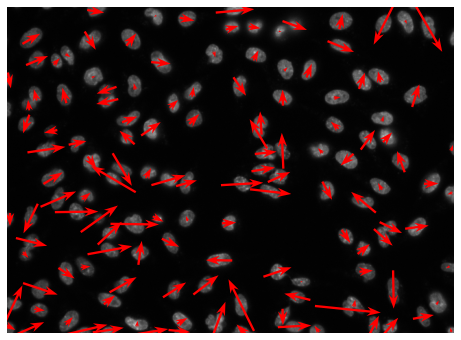

In [ ]:
from matplotlib.pyplot import quiver
i = 0
d = data[data.frame==i]
plt.imshow(my_fl_img[i])
plt.quiver(d.x, d.y, d.dx, -d.dy, pivot='middle', headwidth=4, headlength=6, color='red')
plt.axis('off')